In [1]:
library(lmerTest)
library(MuMIn)
library(VIF)
library(sqldf)
library(car)
library(ggplot2)
library(sjPlot)
library(sjmisc)
library(sjlabelled)
library(ggeffects)


filename <- 'generated/num_of_review_comments.csv'

effectiveCommentsData <- read.csv(file=filename, header=TRUE, sep=",")

effectiveCommentsData$LanguageType = as.factor(effectiveCommentsData$LanguageType)

effectiveCommentsData$EffectiveComments = log(effectiveCommentsData$EffectiveComments + 1)
effectiveCommentsData$Additions = log(effectiveCommentsData$Additions + 1)
effectiveCommentsData$Deletions = log(effectiveCommentsData$Deletions + 1)
effectiveCommentsData$TotalReviewComments = log(effectiveCommentsData$TotalReviewComments + 1)
effectiveCommentsData$TotalReviewCommentThreads = log(effectiveCommentsData$TotalReviewCommentThreads + 1)
effectiveCommentsData$GeneralComments = log(effectiveCommentsData$GeneralComments + 1)
effectiveCommentsData$Commits = log(effectiveCommentsData$Commits + 1)
effectiveCommentsData$Assignees = log(effectiveCommentsData$Assignees + 1)
effectiveCommentsData$ChangedFiles = log(effectiveCommentsData$ChangedFiles + 1)
effectiveCommentsData$PrOpenedDaysAfterProjectStart = log(effectiveCommentsData$PrOpenedDaysAfterProjectStart + 1)
effectiveCommentsData$NumOfUniqueUsers = log(effectiveCommentsData$NumOfUniqueUsers + 1)
effectiveCommentsData$PRsOpened = log(effectiveCommentsData$PRsOpened + 1)
effectiveCommentsData$TotalBuilds = log(effectiveCommentsData$TotalBuilds + 1)
effectiveCommentsData$AdditionsAfterCreate = log(effectiveCommentsData$AdditionsAfterCreate + 1)
effectiveCommentsData$CommitsAfterCreate = log(effectiveCommentsData$CommitsAfterCreate + 1)
effectiveCommentsData$DeletionsAfterCreate = log(effectiveCommentsData$DeletionsAfterCreate + 1)

summary(effectiveCommentsData)

Loading required package: Matrix
Loading required package: lme4

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step

Loading required package: gsubfn
Loading required package: proto
Warning message:
“no DISPLAY variable so Tk is not available”Loading required package: RSQLite

Attaching package: ‘car’

The following object is masked from ‘package:VIF’:

    vif

#refugeeswelcome
Learn more about sjmisc with 'browseVignettes("sjmisc")'.


 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.00000   Min.   :0.0000      Min.   :0.0000           
 1st Qu.:0.00000   1st Qu.:0.0000      1st Qu.:0.0000           
 Median :0.00000   Median :0.0000      Median :0.0000           
 Mean   :0.06041   Mean   :0.3008      Mean   :0.2776           
 3rd Qu.:0.00000   3rd Qu.:0.0000      3rd Qu.:0.0000           
 Max.   :5.56068   Max.   :6.1821      Max.   :6.0039           
                                                                
 ShareReviewComments GeneralComments  GeneralCommentsDiscussingBuild
 Min.   :  0.00      Min.   :0.0000   Min.   :0                     
 1st Qu.:  0.00      1st Qu.:0.0000   1st Qu.:0                     
 Median :  0.00      Median :0.6931   Median :0                     
 Mean   : 10.44      Mean   :0.8905   Mean   :0                     
 3rd Qu.:  0.00      3rd Qu.:1.3863   3rd Qu.:0                     
 Max.   :100.00      Max.   :6.9431   Max.   :0                   

In [2]:
hasEffectiveComments <- sqldf("select *
                      from 'effectiveCommentsData' 
                      where EffectiveComments > 0")

print(nrow(hasEffectiveComments))

summary(hasEffectiveComments)

no_linter_static = nrow(subset(hasEffectiveComments, Linter == 'False' & LanguageType == 'static'))
linter_static = nrow(subset(hasEffectiveComments, Linter == 'True' & LanguageType == 'static'))

no_linter_dynamic = nrow(subset(hasEffectiveComments, Linter == 'False' & LanguageType == 'dynamic'))
linter_dynamic = nrow(subset(hasEffectiveComments, Linter == 'True' & LanguageType == 'dynamic'))


print(no_linter_static)
print(linter_static)

print(no_linter_dynamic)
print(linter_dynamic)

[1] 15237


 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.6931    Min.   :0.6931      Min.   :0.6931           
 1st Qu.:0.6931    1st Qu.:1.0986      1st Qu.:1.0986           
 Median :1.0986    Median :1.7918      Median :1.6094           
 Mean   :1.2956    Mean   :1.9242      Mean   :1.7810           
 3rd Qu.:1.6094    3rd Qu.:2.5649      3rd Qu.:2.3979           
 Max.   :5.5607    Max.   :6.1821      Max.   :5.8522           
                                                                
 ShareReviewComments GeneralComments GeneralCommentsDiscussingBuild
 Min.   :  1.19      Min.   :0.000   Min.   :0                     
 1st Qu.: 36.36      1st Qu.:1.099   1st Qu.:0                     
 Median : 59.09      Median :1.609   Median :0                     
 Mean   : 58.03      Mean   :1.630   Mean   :0                     
 3rd Qu.: 80.00      3rd Qu.:2.197   3rd Qu.:0                     
 Max.   :100.00      Max.   :6.136   Max.   :0                     
    

[1] 1466
[1] 4161
[1] 3189
[1] 4014


# Hurdle

First we make a hurdle model to determine whether we can detect zero pull requests vs non zero pull requests. We pick an equal amount of pull requests with zero and non zero effective comments and then build a linear regression. 

In [3]:
zerosdf <- sqldf('select * from "effectiveCommentsData" where EffectiveComments = 0 and LanguageType != "unk"')

sampledZerosdf <- zerosdf[sample(nrow(zerosdf), nrow(sqldf('select * from hasEffectiveComments where LanguageType != "unk"'))),]

combined <- rbind(sampledZerosdf, sqldf('select * from hasEffectiveComments where LanguageType != "unk"'))

baseHurdleModel = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Coverage +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(baseHurdleModel)
r.squaredGLMM(baseHurdleModel)
vif(baseHurdleModel)
anova(baseHurdleModel)


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Coverage + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + GeneralComments + 
    LanguageType + IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4316  -0.5389  -0.0156   0.6456   2.9979  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -6.15987    0.18398 -33.482  < 2e-16 ***
Additions                      0.21081    0.01416  14.893  < 2e-16 ***
Deletions                     -0.11256    0.01401  -8.034 9.44e-16 ***
IsMergedTrue                   0.81742    0.04265  19.167  < 2e-16 ***
Commits                        1.34322    0.03193  42.069  < 2e-16 ***
LinterTrue                     0.25061    0.03704   6.766 1.32e-11 ***
CoverageTrue              

R2m      R2c 
0.657919 0.657919

Additions                     Deletions 
                     3.238980                      2.636487 
                     IsMerged                       Commits 
                     1.156689                      1.393203 
                       Linter                      Coverage 
                     1.049054                      1.111182 
                    Assignees                  ChangedFiles 
                     1.040574                      3.857258 
             NumOfUniqueUsers                     PRsOpened 
                     2.188063                      2.989127 
                  TotalBuilds                NewContributor 
                     3.011909                      1.739419 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.828113                      1.938292 
              GeneralComments                  LanguageType 
                     2.228514                      1.203759 
                      IsAfter 
                     3.764744

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25659,35572.31
Additions,1,2940.8294060,25658,32631.48
Deletions,1,124.1826539,25657,32507.30
IsMerged,1,23.2412257,25656,32484.06
Commits,1,5611.0290927,25655,26873.03
Linter,1,108.5911546,25654,26764.44
Coverage,1,7.9807718,25653,26756.46
Assignees,1,162.5676655,25652,26593.89
ChangedFiles,1,100.5491310,25651,26493.34
NumOfUniqueUsers,1,5274.7893697,25650,21218.55


# Interaction between LanguageType and Travis adoption


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Coverage + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + GeneralComments + 
    LanguageType * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4307  -0.5400  -0.0154   0.6449   3.0057  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -6.14541    0.18425 -33.354  < 2e-16 ***
Additions                       0.21047    0.01416  14.867  < 2e-16 ***
Deletions                      -0.11241    0.01401  -8.022 1.04e-15 ***
IsMergedTrue                    0.81581    0.04266  19.124  < 2e-16 ***
Commits                         1.34276    0.03193  42.047  < 2e-16 ***
LinterTrue                      0.25132    0.03704   6.785 1.16e-11 ***
CoverageTrue       

R2m       R2c 
0.6580022 0.6580022

Additions                     Deletions 
                     3.239052                      2.636978 
                     IsMerged                       Commits 
                     1.157354                      1.393342 
                       Linter                      Coverage 
                     1.049163                      1.111477 
                    Assignees                  ChangedFiles 
                     1.041084                      3.856581 
             NumOfUniqueUsers                     PRsOpened 
                     2.188383                      2.991513 
                  TotalBuilds                NewContributor 
                     3.028312                      1.739773 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.833235                      1.939031 
              GeneralComments                  LanguageType 
                     2.228927                      2.362254 
                      IsAfter          LanguageType:IsAfter 
                     4.853490                      2.948310

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25659,35572.31
Additions,1,2940.8294060,25658,32631.48
Deletions,1,124.1826539,25657,32507.30
IsMerged,1,23.2412257,25656,32484.06
Commits,1,5611.0290927,25655,26873.03
Linter,1,108.5911546,25654,26764.44
Coverage,1,7.9807718,25653,26756.46
Assignees,1,162.5676655,25652,26593.89
ChangedFiles,1,100.5491310,25651,26493.34
NumOfUniqueUsers,1,5274.7893697,25650,21218.55


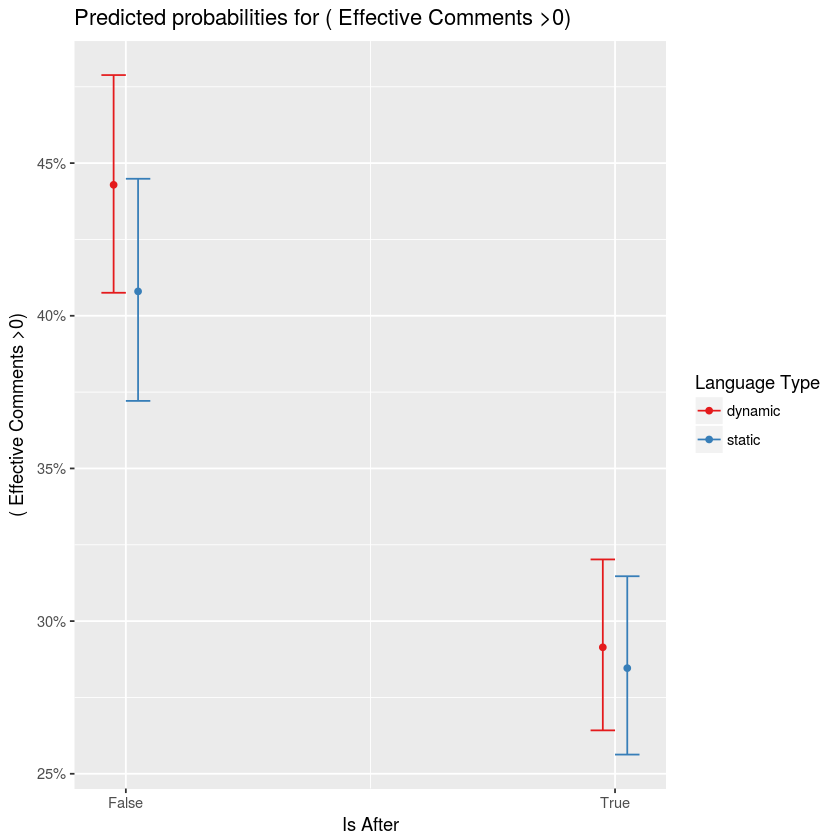

In [4]:
baseHurdleModelInteraction = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Coverage +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType *
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(baseHurdleModelInteraction)
r.squaredGLMM(baseHurdleModelInteraction)
vif(baseHurdleModelInteraction)
anova(baseHurdleModelInteraction)

plot_model(baseHurdleModelInteraction, type="pred", terms=c('IsAfter', 'LanguageType'))

# Interaction between Coverage usage and Travis adoption


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Linter + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + GeneralComments + 
    LanguageType + Coverage * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4325  -0.5398  -0.0157   0.6455   2.9942  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -6.14932    0.18525 -33.195  < 2e-16 ***
Additions                      0.21088    0.01416  14.896  < 2e-16 ***
Deletions                     -0.11255    0.01401  -8.033 9.51e-16 ***
IsMergedTrue                   0.81678    0.04267  19.143  < 2e-16 ***
Commits                        1.34370    0.03194  42.063  < 2e-16 ***
LinterTrue                     0.25043    0.03704   6.761 1.37e-11 ***
Assignees                 

R2m       R2c 
0.6578922 0.6578922

Additions                     Deletions 
                     3.239520                      2.636792 
                     IsMerged                       Commits 
                     1.157732                      1.394600 
                       Linter                     Assignees 
                     1.049110                      1.041523 
                 ChangedFiles              NumOfUniqueUsers 
                     3.857559                      2.189294 
                    PRsOpened                   TotalBuilds 
                     2.993522                      3.021473 
               NewContributor PrOpenedDaysAfterProjectStart 
                     1.740296                      1.828451 
                 FromOutsider               GeneralComments 
                     1.938346                      2.228612 
                 LanguageType                      Coverage 
                     1.203724                      2.310358 
                      IsAfter              Coverage:IsAfter 
                     4.367335                      3.079054

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25659,35572.31
Additions,1,2940.8294060,25658,32631.48
Deletions,1,124.1826539,25657,32507.30
IsMerged,1,23.2412257,25656,32484.06
Commits,1,5611.0290927,25655,26873.03
Linter,1,108.5911546,25654,26764.44
Assignees,1,168.3260024,25653,26596.11
ChangedFiles,1,100.8263660,25652,26495.29
NumOfUniqueUsers,1,5268.7465561,25651,21226.54
PRsOpened,1,19.6325816,25650,21206.91


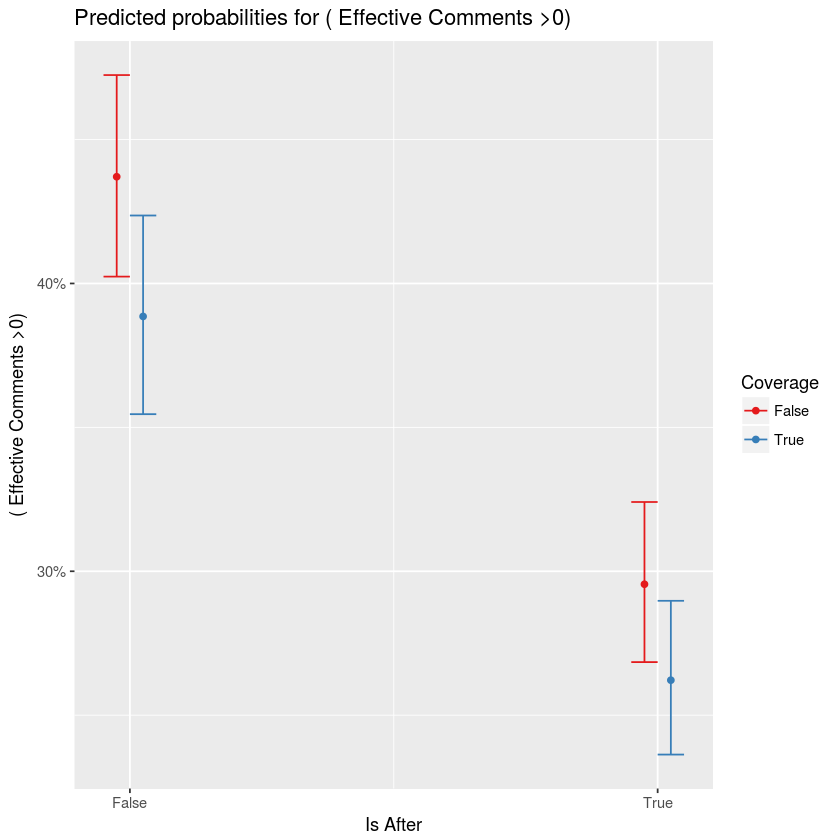

In [5]:
hurdleModelInteractionCoverage = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Linter +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType +
                                         Coverage*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionCoverage)
r.squaredGLMM(hurdleModelInteractionCoverage)
vif(hurdleModelInteractionCoverage)
anova(hurdleModelInteractionCoverage)

plot_model(hurdleModelInteractionCoverage, type="pred", terms=c('IsAfter', 'Coverage'))

# Interaction Linter with Travis Introduction


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Coverage + Assignees + ChangedFiles + 
    NumOfUniqueUsers + PRsOpened + TotalBuilds + NewContributor + 
    PrOpenedDaysAfterProjectStart + FromOutsider + GeneralComments + 
    LanguageType + Linter * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4286  -0.5406  -0.0154   0.6462   3.0008  

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -6.18800    0.18645 -33.188  < 2e-16 ***
Additions                      0.21078    0.01416  14.889  < 2e-16 ***
Deletions                     -0.11251    0.01401  -8.030 9.73e-16 ***
IsMergedTrue                   0.81630    0.04266  19.135  < 2e-16 ***
Commits                        1.34376    0.03194  42.074  < 2e-16 ***
CoverageTrue                  -0.18173    0.03708  -4.900 9.56e-07 ***
Assignees                 

R2m       R2c 
0.6579735 0.6579735

Additions                     Deletions 
                     3.238985                      2.636160 
                     IsMerged                       Commits 
                     1.157605                      1.393791 
                     Coverage                     Assignees 
                     1.110880                      1.040728 
                 ChangedFiles              NumOfUniqueUsers 
                     3.857173                      2.188893 
                    PRsOpened                   TotalBuilds 
                     2.991404                      3.010508 
               NewContributor PrOpenedDaysAfterProjectStart 
                     1.740155                      1.828355 
                 FromOutsider               GeneralComments 
                     1.940454                      2.231201 
                 LanguageType                        Linter 
                     1.203942                      2.221987 
                      IsAfter                Linter:IsAfter 
                     5.473215                      3.841870

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25659,35572.31
Additions,1,2940.8294060,25658,32631.48
Deletions,1,124.1826539,25657,32507.30
IsMerged,1,23.2412257,25656,32484.06
Commits,1,5611.0290927,25655,26873.03
Coverage,1,7.4661637,25654,26865.56
Assignees,1,152.4708914,25653,26713.09
ChangedFiles,1,102.9051090,25652,26610.19
NumOfUniqueUsers,1,5350.4949408,25651,21259.69
PRsOpened,1,21.5702008,25650,21238.12


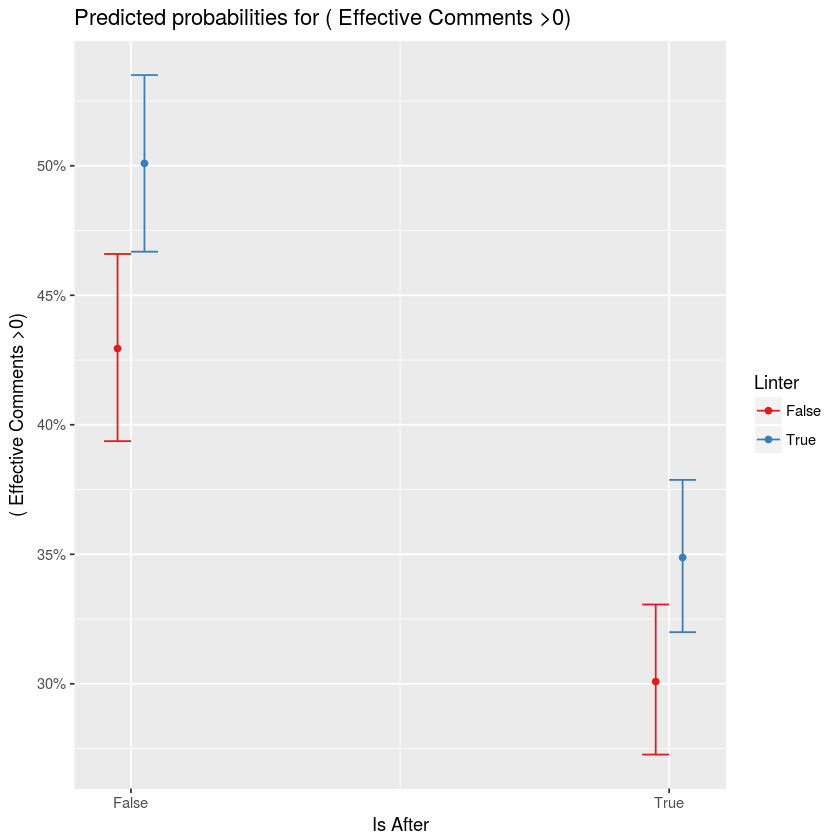

In [6]:
hurdleModelInteractionLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Coverage +
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType +
                                         Linter*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLinter)
r.squaredGLMM(hurdleModelInteractionLinter)
vif(hurdleModelInteractionLinter)
anova(hurdleModelInteractionLinter)

plot_model(hurdleModelInteractionLinter, type="pred", terms=c('IsAfter', 'Linter'))

# Interaction between coverage, linter and Travis introduction


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + GeneralComments + LanguageType + Coverage * 
    Linter * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.3911  -0.5427  -0.0145   0.6420   3.0386  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -6.25685    0.18977 -32.971  < 2e-16 ***
Additions                            0.21335    0.01416  15.066  < 2e-16 ***
Deletions                           -0.11171    0.01403  -7.965 1.66e-15 ***
IsMergedTrue                         0.81701    0.04274  19.117  < 2e-16 ***
Commits                              1.34599    0.03202  42.039  < 2e-16 ***
Assignees                            0.87857    0.08358  10.5

R2m      R2c 
0.660242 0.660242

Additions                     Deletions 
                     3.238242                      2.640070 
                     IsMerged                       Commits 
                     1.159266                      1.397568 
                    Assignees                  ChangedFiles 
                     1.047358                      3.866382 
             NumOfUniqueUsers                     PRsOpened 
                     2.191857                      2.998768 
                  TotalBuilds                NewContributor 
                     3.028500                      1.743157 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.835778                      1.959672 
              GeneralComments                  LanguageType 
                     2.232620                      1.259165 
                     Coverage                        Linter 
                     6.268083                      3.821818 
                      IsAfter               Coverage:Linter 
                     7.464938                      7.849189 
             Coverage:IsAfter                Linter:IsAfter 
                     8.224397                      6.904466 
      Coverage:Linter:IsAfter 
                     9.275901

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25659,35572.31
Additions,1,2.940829e+03,25658,32631.48
Deletions,1,1.241827e+02,25657,32507.30
IsMerged,1,2.324123e+01,25656,32484.06
Commits,1,5.611029e+03,25655,26873.03
Assignees,1,1.578848e+02,25654,26715.15
ChangedFiles,1,1.031948e+02,25653,26611.95
NumOfUniqueUsers,1,5.343815e+03,25652,21268.14
PRsOpened,1,2.300062e+01,25651,21245.14
TotalBuilds,1,2.788223e+02,25650,20966.31


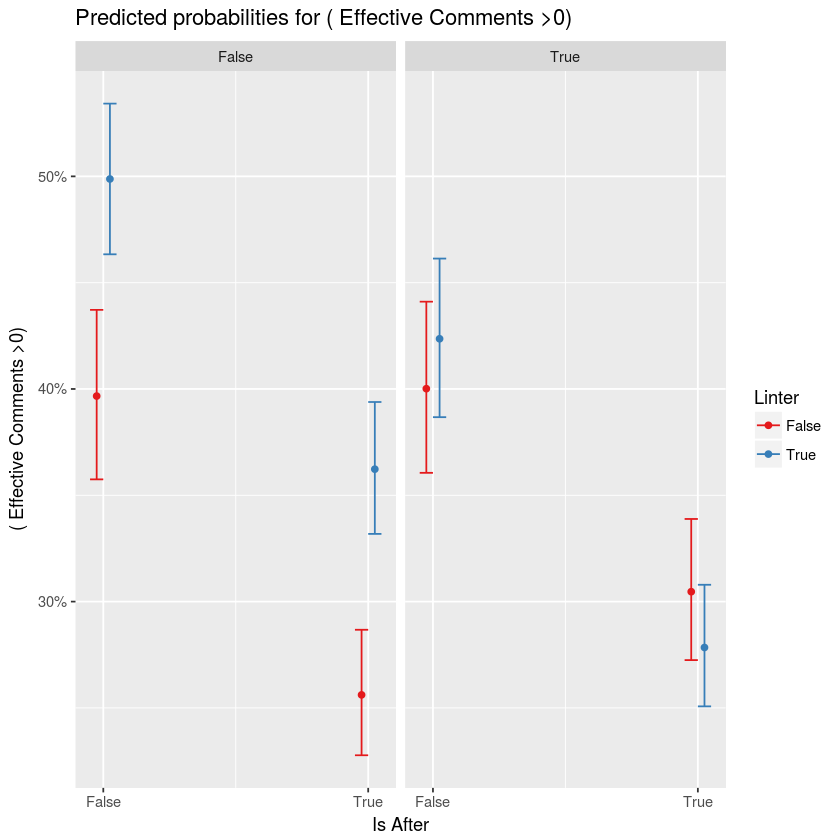

In [7]:
hurdleModelInteractionCoverageLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType +
                                           Coverage*
                                         Linter*
            IsAfter ,
          data=combined,
                 family = 'binomial')
summary(hurdleModelInteractionCoverageLinter)
r.squaredGLMM(hurdleModelInteractionCoverageLinter)
vif(hurdleModelInteractionCoverageLinter)
anova(hurdleModelInteractionCoverageLinter)

plot_model(hurdleModelInteractionCoverageLinter, type="pred", terms=c('IsAfter', 'Linter', 'Coverage'))

# Interaction between language type, linter and travis


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + GeneralComments + Coverage + LanguageType * 
    Linter * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4176  -0.5428  -0.0150   0.6451   3.0234  

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                               -6.14785    0.18976 -32.398  < 2e-16
Additions                                  0.21022    0.01416  14.842  < 2e-16
Deletions                                 -0.11189    0.01402  -7.982 1.44e-15
IsMergedTrue                               0.81083    0.04270  18.988  < 2e-16
Commits                                    1.34400    0.03197  42.046  < 2e-16
Assignees                                  0.8425

R2m       R2c 
0.6585066 0.6585066

Additions                     Deletions 
                     3.241287                      2.637943 
                     IsMerged                       Commits 
                     1.160369                      1.395037 
                    Assignees                  ChangedFiles 
                     1.043776                      3.858932 
             NumOfUniqueUsers                     PRsOpened 
                     2.189029                      2.996119 
                  TotalBuilds                NewContributor 
                     3.029787                      1.741011 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.841391                      1.948051 
              GeneralComments                      Coverage 
                     2.231814                      1.174311 
                 LanguageType                        Linter 
                     7.058551                      3.760867 
                      IsAfter           LanguageType:Linter 
                     6.986628                      9.015530 
         LanguageType:IsAfter                Linter:IsAfter 
                     8.752415                      6.565983 
  LanguageType:Linter:IsAfter 
                    10.298853

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25659,35572.31
Additions,1,2940.8294060,25658,32631.48
Deletions,1,124.1826539,25657,32507.30
IsMerged,1,23.2412257,25656,32484.06
Commits,1,5611.0290927,25655,26873.03
Assignees,1,157.8847517,25654,26715.15
ChangedFiles,1,103.1947636,25653,26611.95
NumOfUniqueUsers,1,5343.8147801,25652,21268.14
PRsOpened,1,23.0006165,25651,21245.14
TotalBuilds,1,278.8223433,25650,20966.31


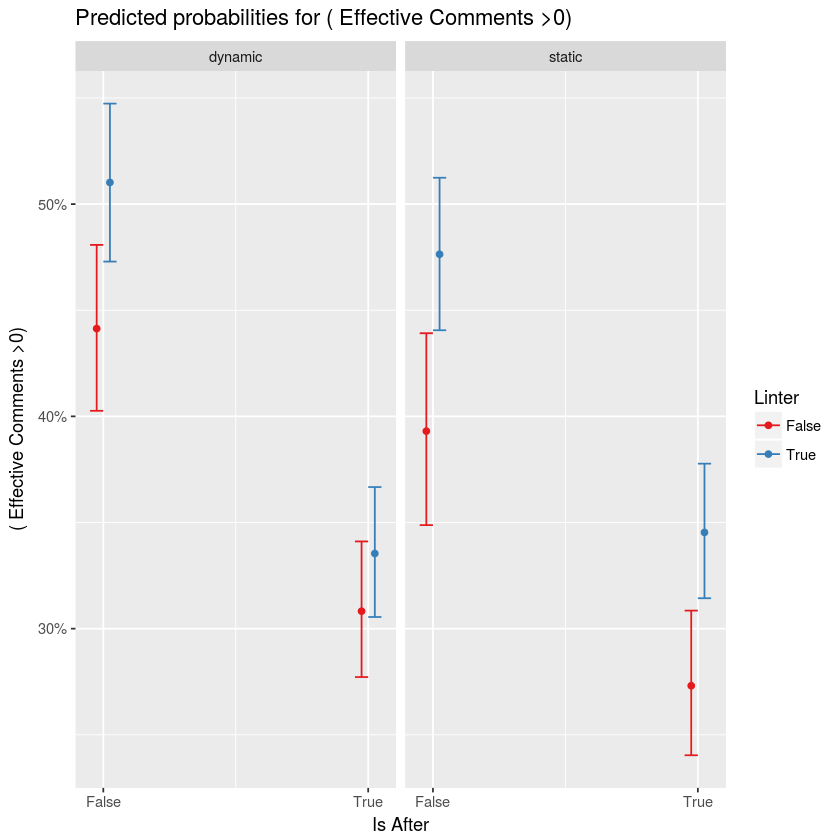

In [8]:
hurdleModelInteractionLanguageLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            Coverage +
            LanguageType *
            Linter*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLanguageLinter)
r.squaredGLMM(hurdleModelInteractionLanguageLinter)
vif(hurdleModelInteractionLanguageLinter)
anova(hurdleModelInteractionLanguageLinter)

plot_model(hurdleModelInteractionLanguageLinter, type="pred", terms=c('IsAfter', 'Linter', 'LanguageType'))

# Interaction between langauge type, coverage and Travis


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + GeneralComments + Linter + LanguageType * 
    Coverage * IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.4283  -0.5409  -0.0156   0.6465   3.0031  

Coefficients:
                                            Estimate Std. Error z value
(Intercept)                                 -6.12403    0.18663 -32.813
Additions                                    0.21038    0.01417  14.849
Deletions                                   -0.11244    0.01402  -8.022
IsMergedTrue                                 0.81422    0.04270  19.068
Commits                                      1.34403    0.03199  42.013
Assignees                                    0.84741    0.08345  10.155
ChangedFiles       

R2m       R2c 
0.6578938 0.6578938

Additions                     Deletions 
                     3.243871                      2.638110 
                     IsMerged                       Commits 
                     1.159503                      1.398097 
                    Assignees                  ChangedFiles 
                     1.045405                      3.862407 
             NumOfUniqueUsers                     PRsOpened 
                     2.189937                      2.998154 
                  TotalBuilds                NewContributor 
                     3.042211                      1.741443 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.841551                      1.940048 
              GeneralComments                        Linter 
                     2.232225                      1.102733 
                 LanguageType                      Coverage 
                     3.920461                      4.038167 
                      IsAfter         LanguageType:Coverage 
                     7.152628                      4.693514 
         LanguageType:IsAfter              Coverage:IsAfter 
                     5.317901                      5.545161 
LanguageType:Coverage:IsAfter 
                     5.035627

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25659,35572.31
Additions,1,2940.8294060,25658,32631.48
Deletions,1,124.1826539,25657,32507.30
IsMerged,1,23.2412257,25656,32484.06
Commits,1,5611.0290927,25655,26873.03
Assignees,1,157.8847517,25654,26715.15
ChangedFiles,1,103.1947636,25653,26611.95
NumOfUniqueUsers,1,5343.8147801,25652,21268.14
PRsOpened,1,23.0006165,25651,21245.14
TotalBuilds,1,278.8223433,25650,20966.31


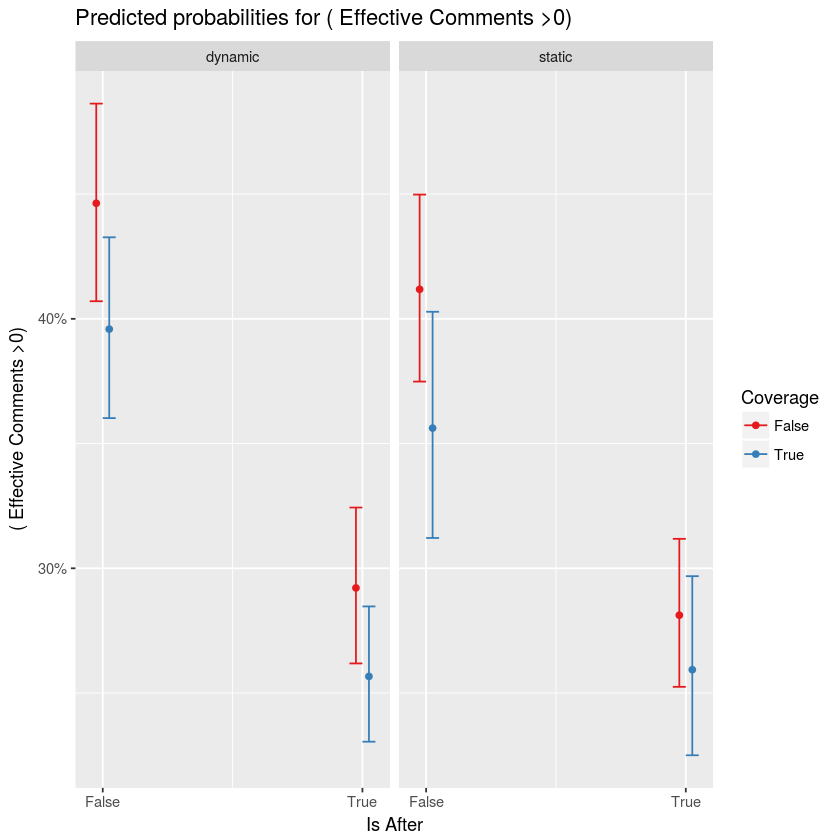

In [9]:
hurdleModelInteractionLanguageCoverage = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            Linter +
            LanguageType *
            Coverage*
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLanguageCoverage)
r.squaredGLMM(hurdleModelInteractionLanguageCoverage)
vif(hurdleModelInteractionLanguageCoverage)
anova(hurdleModelInteractionLanguageCoverage)

plot_model(hurdleModelInteractionLanguageCoverage, type="pred", terms=c('IsAfter', 'Coverage', 'LanguageType'))

# Interaction between language type, coverage and linter (no travis!)


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + GeneralComments + LanguageType * Linter * 
    Coverage + IsAfter, family = "binomial", data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.3721  -0.5433  -0.0147   0.6393   3.0511  

Coefficients:
                                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                                -6.36165    0.19020 -33.447  < 2e-16
Additions                                   0.21440    0.01419  15.114  < 2e-16
Deletions                                  -0.11394    0.01404  -8.113 4.93e-16
IsMergedTrue                                0.82542    0.04276  19.303  < 2e-16
Commits                                     1.34869    0.03208  42.047  < 2e-16
Assignees                                  

R2m       R2c 
0.6604297 0.6604297

Additions                     Deletions 
                     3.245213                      2.643148 
                     IsMerged                       Commits 
                     1.159559                      1.398306 
                    Assignees                  ChangedFiles 
                     1.053492                      3.866443 
             NumOfUniqueUsers                     PRsOpened 
                     2.191137                      3.005547 
                  TotalBuilds                NewContributor 
                     3.020737                      1.743306 
PrOpenedDaysAfterProjectStart                  FromOutsider 
                     1.839178                      1.959471 
              GeneralComments                  LanguageType 
                     2.232709                      5.087671 
                       Linter                      Coverage 
                     4.261666                      4.481536 
                      IsAfter           LanguageType:Linter 
                     3.777076                      6.951191 
        LanguageType:Coverage               Linter:Coverage 
                    17.643294                      6.291431 
 LanguageType:Linter:Coverage 
                    19.593141

,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,25659,35572.31
Additions,1,2.940829e+03,25658,32631.48
Deletions,1,1.241827e+02,25657,32507.30
IsMerged,1,2.324123e+01,25656,32484.06
Commits,1,5.611029e+03,25655,26873.03
Assignees,1,1.578848e+02,25654,26715.15
ChangedFiles,1,1.031948e+02,25653,26611.95
NumOfUniqueUsers,1,5.343815e+03,25652,21268.14
PRsOpened,1,2.300062e+01,25651,21245.14
TotalBuilds,1,2.788223e+02,25650,20966.31


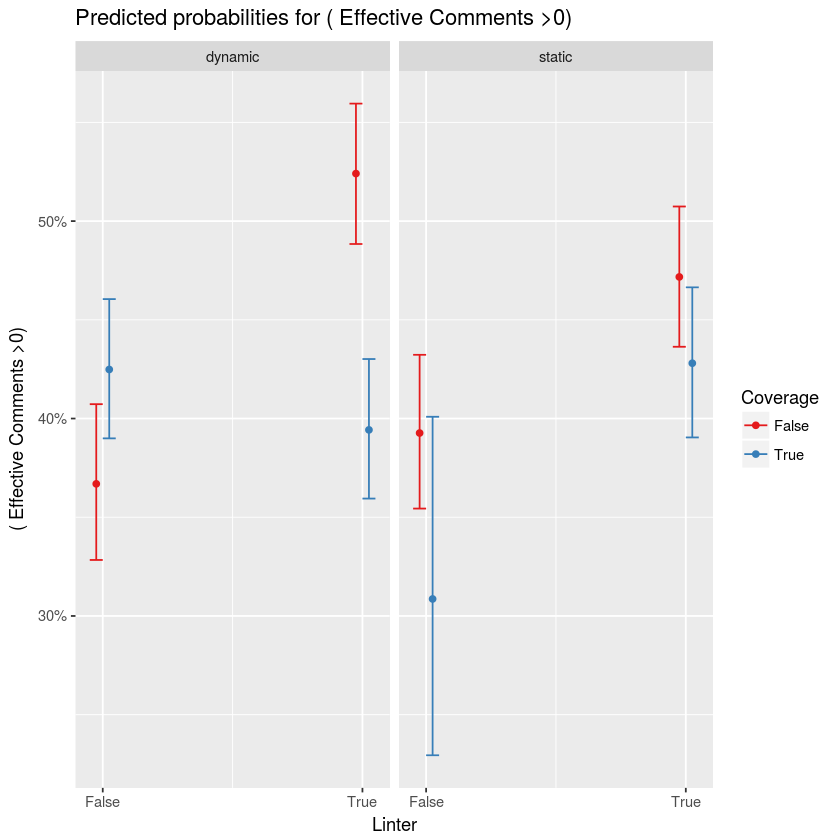

In [10]:
hurdleModelInteractionLanguageCoverageLinter = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType *
            Linter*
            Coverage+
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModelInteractionLanguageCoverageLinter)
r.squaredGLMM(hurdleModelInteractionLanguageCoverageLinter)
vif(hurdleModelInteractionLanguageCoverageLinter)
anova(hurdleModelInteractionLanguageCoverageLinter)

plot_model(hurdleModelInteractionLanguageCoverageLinter, type="pred", terms=c('Linter', 'Coverage', 'LanguageType'))

# Linear models!

In [11]:
executeLmOnData <- function(formula, data) {
    model = lm(formula ,
          data= data)
    print(summary(model))
    #r.squaredGLMM(model)
    print(vif(model))
    print(anova(model))
    
    return(model)
}

In [12]:
baseModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            Linter +
            Coverage +
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            IsAfter ,
        hasEffectiveComments)


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7907 -0.4421 -0.1273  0.3245  3.7134 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.8719147  0.0566873  15.381  < 2e-16 ***
Additions                      0.0976471  0.0040409  24.164  < 2e-16 ***
Deletions                     -0.0498774  0.0036966 -13.493  < 2e-16 ***
IsMergedTrue                  -0.0115944  0.0134107  -0.865  0.38729    
Assignees                      0.0667742  0.0216579   3.083  0.00205 ** 
LinterTrue                     0.0054916  0.0107169   0.512  0.60836    
CoverageTrue                   0.0090638  0.0110265   0.822  0.41109    
ChangedFiles                  -0.0009019  0.0091663  -0.098  0.92163    
NumOfUniqueUsers               0.2799062  0.0193803  14.443  < 2e-16 ***
PRsOpened                     -0.0203913  0.0044346  -4.598 4.30e-06 ***
TotalBuilds                    0.1719515  0.00

# Language type

This cell introduces language type (dynamic / static / unk) to the linear model. This shows a very small increase in the accuracy of the model.

Commits, additions and deletions after create are not included because of high vif scores. 

In [13]:
ltypeModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            Linter +
            Coverage +
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType +
                IsAfter ,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType != 'unk'
")
        )


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7969 -0.4490 -0.1233  0.3306  3.7327 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.832533   0.062027  13.422  < 2e-16 ***
Additions                      0.097887   0.004525  21.634  < 2e-16 ***
Deletions                     -0.051416   0.004063 -12.656  < 2e-16 ***
IsMergedTrue                  -0.015279   0.014593  -1.047 0.295123    
Assignees                      0.076092   0.024146   3.151 0.001629 ** 
LinterTrue                     0.006357   0.012420   0.512 0.608773    
CoverageTrue                  -0.003255   0.012364  -0.263 0.792328    
ChangedFiles                   0.009985   0.010208   0.978 0.327998    
NumOfUniqueUsers               0.282731   0.021533  13.130  < 2e-16 ***
PRsOpened                     -0.016849   0.004996  -3.373 0.000747 ***
TotalBuilds                    0.175746   0.010004  17.56

## Language type as interaction effect

Adding in language type as in interaction effect with IsAfter does not appear to have any effect on the accuracy of the model. 


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8138 -0.4481 -0.1223  0.3331  3.7174 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     0.828915   0.062039  13.361  < 2e-16 ***
Additions                       0.097925   0.004524  21.646  < 2e-16 ***
LinterTrue                      0.006246   0.012418   0.503 0.614963    
CoverageTrue                   -0.002910   0.012363  -0.235 0.813951    
Deletions                      -0.051439   0.004062 -12.663  < 2e-16 ***
IsMergedTrue                   -0.014190   0.014599  -0.972 0.331081    
Assignees                       0.075151   0.024146   3.112 0.001860 ** 
ChangedFiles                    0.010290   0.010207   1.008 0.313394    
NumOfUniqueUsers                0.282637   0.021530  13.128  < 2e-16 ***
PRsOpened                      -0.017382   0.005001  -3.476 0.000511 ***
TotalBuilds                     0.174893   0.0

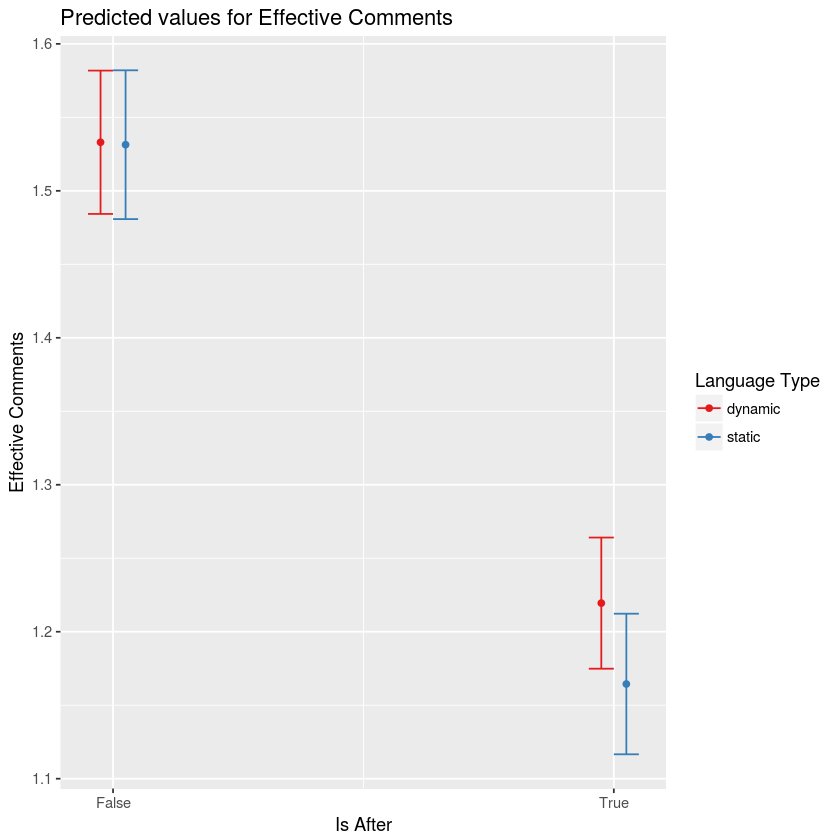

In [14]:
ltypeInteraction <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Linter +
            Coverage +
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
            LanguageType *
            IsAfter ,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType != 'unk'
"))

plot_model(ltypeInteraction, type="pred", terms=c('IsAfter', 'LanguageType'))

# Finding projects that experience more effect from Travis

In [15]:
projectNames = sqldf('Select distinct(ProjectName) from hasEffectiveComments')$ProjectName

projectResults = data.frame(ProjectName=character(),
                            PRs = integer(),
                           PValue=double(),
                            R2=double(),
                           Coefficient=double(),
                           PercentageExplained=double(),
                            ModelType=character(),
                           stringsAsFactors=FALSE)

for(project in projectNames) {
        formula <- EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
                IsAfter
    
    data <- sqldf(sprintf("select * from hasEffectiveComments
                    where ProjectName ='%s'", project))
    
    data$IsMerged <- factor(data$IsMerged)
    data$NewContributor <- factor(data$NewContributor)
    data$FromOutsider <- factor(data$FromOutsider)
    data$IsAfter <- factor(data$IsAfter)
    
    #Skip running an analysis if there is not enough data
    if(nlevels(data$IsMerged) > 1 &
      nlevels(data$NewContributor) > 1 &
      nlevels(data$FromOutsider) > 1 &
      nlevels(data$IsAfter) > 1)
    {    
        model_per_project <- lm(formula, data=data)
        
        pVals <- summary(model_per_project)$coefficients[,"Pr(>|t|)"]
        
        pOfIsAfter <- NA
        percentageExplained <- NA
        
        if("IsAfterTrue" %in% names(pVals)) {
            pOfIsAfter <- pVals[["IsAfterTrue"]]
        
            av <- anova(model_per_project)
            
            isAfterSum <- av$"Sum Sq"[length(av$"Sum Sq")]
        
            total <- 0
            for(sQrs in av$"Sum Sq") {
                total = sQrs + total
            }
        
            percentageExplained = isAfterSum / total * 100
        }
        
        
        coefs <- coef(model_per_project)
        
        isAfterCoef <- coefs[["IsAfterTrue"]]
        
        row <- data.frame(
                        ProjectName=project,
                            PRs = nrow(data),
                           PValue=pOfIsAfter,
                            R2=summary(model_per_project)$r.squared,
                           Coefficient=isAfterCoef,
                           PercentageExplained=percentageExplained,
                            ModelType = "Non-Hurdle",
                           stringsAsFactors=FALSE)
        
        projectResults <- rbind(projectResults, row)
    }
}

Warning message in anova.lm(model_per_project):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(model_per_project):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(model_per_project):
“ANOVA F-tests on an essentially perfect fit are unreliable”

In [16]:
projectNames = sqldf('Select distinct(ProjectName) from hasEffectiveComments')$ProjectName

for(project in projectNames) {
        formula <- (EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            GeneralComments + 
                IsAfter
    
    zerosdf_project <- sqldf(sprintf('select * from "effectiveCommentsData" where EffectiveComments = 0 and ProjectName="%s"',project))

    sampledZerosdf_project <- zerosdf_project[sample(nrow(zerosdf_project), nrow(sqldf(sprintf('select * from hasEffectiveComments where ProjectName="%s"', project)))),]

    combined_project <- rbind(sampledZerosdf_project, sqldf(sprintf("select * from hasEffectiveComments
                    where ProjectName ='%s'", project)))

    
    combined_project$IsMerged <- factor(combined_project$IsMerged)
    combined_project$NewContributor <- factor(combined_project$NewContributor)
    combined_project$FromOutsider <- factor(combined_project$FromOutsider)
    combined_project$IsAfter <- factor(combined_project$IsAfter)
    
    #Skip running an analysis if there is not enough data
    if(nlevels(combined_project$IsMerged) > 1 &
      nlevels(combined_project$NewContributor) > 1 &
      nlevels(combined_project$FromOutsider) > 1 &
      nlevels(combined_project$IsAfter) > 1)
    {    
        model_per_project <- glm(formula, data=combined_project)
        
        pVals <- summary(model_per_project)$coefficients[,"Pr(>|t|)"]
        
        pOfIsAfter <- NA
        percentageExplained <- NA
        
        if("IsAfterTrue" %in% names(pVals)) {
            pOfIsAfter <- pVals[["IsAfterTrue"]]
            
            if(is.na(pOfIsAfter)) {
                next
            }
            
            av = anova(model_per_project)
            
            isAfterSum <- av$Deviance[length(av$Deviance)]
        
            total <- 0
            for(sQrs in av$Deviance) {
                if( !is.na(sQrs)) {
                total = sQrs + total
                    }
            }
            
            if(total == 0) {
                next
            }
        
            percentageExplained = isAfterSum / total * 100
        }
        
        
        coefs <- coef(model_per_project)
        
        isAfterCoef <- coefs[["IsAfterTrue"]]
        
        row <- data.frame(
                        ProjectName=project,
                            PRs = nrow(combined_project),
                           PValue=pOfIsAfter,
                            R2=r.squaredGLMM(model_per_project)[["R2m"]],
                           Coefficient=isAfterCoef,
                           PercentageExplained=percentageExplained,
                            ModelType = "Hurdle",
                           stringsAsFactors=FALSE)
        
        projectResults <- rbind(projectResults, row)
    }
}

In [17]:


write.csv(projectResults, file = "generated/coefficients.csv",row.names=FALSE, na="")